In [ ]:
!pip install pygad

In [ ]:
!pip install numpy==1.25.2

  Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.25.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.25.2 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.13.0 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.13.0 which is incompatible.
nibabel 5.3.2 requires typing-extensions>=4.6; python_version < 

In [ ]:
!pip install tensorflow==2.13.0

In [ ]:
import tensorflow as tf
import keras
import zipfile
from google.colab import drive
import glob
from PIL import Image
import os
import pygad
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import json

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading dataset from: /content/drive/My Drive/combined_static_features_binary_top500.csv
Dataset shape: (12000, 2031)
Feature count: 2027
Label distribution:
label
1    6000
0    6000
Name: count, dtype: int64
Training samples: 9600, Test samples: 2400

===== Starting Genetic Algorithm for Binary Neural Network Optimization =====
Starting Genetic Algorithm optimization for binary classification neural network...

Generation 1/15
Evaluating chromosome 1/20...
Chromosome: {'num_layers': 2, 'neurons': [128, 256, 32, 32], 'dropout_rates': [0.229030630304203, 0.2490323597007995, 0.2429220476967612, 0.14607545306941902], 'learning_rate': 0.001, 'batch_size': 128}
Fitness (val accuracy): 0.9370
Evaluating chromosome 2/20...
Chromosome: {'num_layers': 4, 'neurons': [64, 256, 256, 256], 'dropout_rates': [0.14167271222947642, 0.44568180661659995, 0.30841894603033604, 0.4794768205017187], 'learning_rate': 0.0005, 'batch_size': 16}
Fitness (val accuracy): 0.9375
Evaluating chromosome 3/20...
Chrom

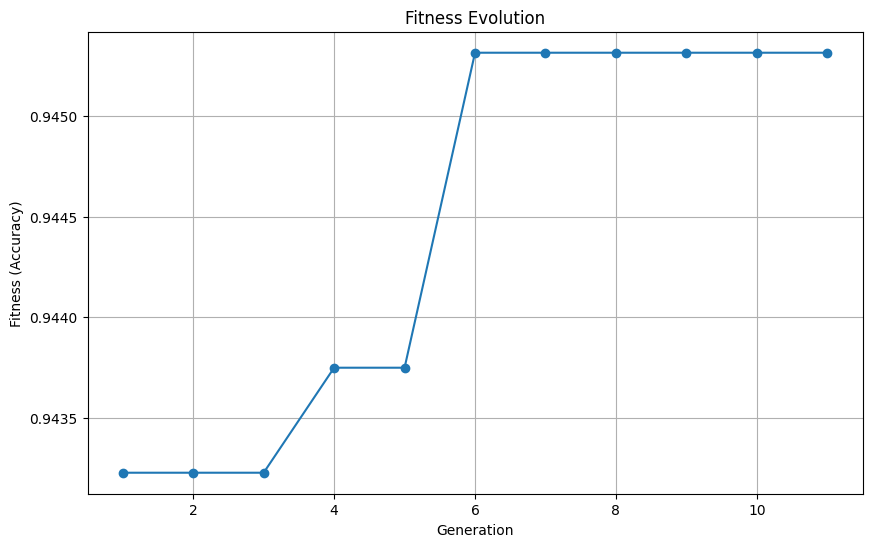

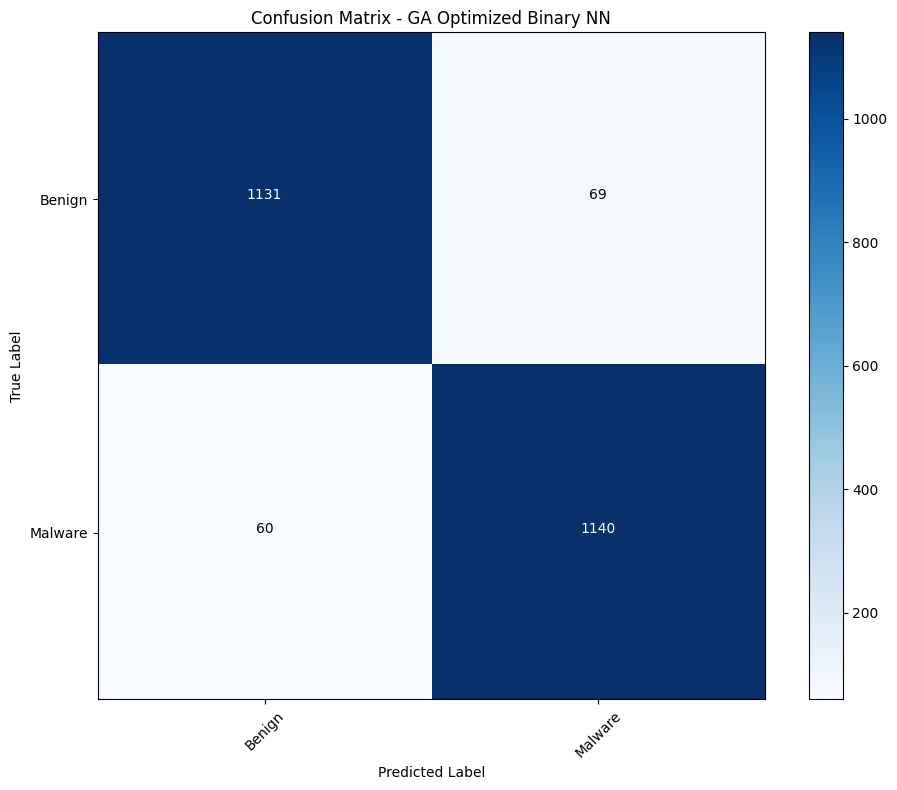

In [ ]:
#GA-MLP
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import keras

# ----- Load Dataset -----
base_dir = '/content/drive/My Drive/'
csv_path = os.path.join(base_dir, 'combined_static_features_binary_top500.csv')
df = pd.read_csv(csv_path)

print(f"Loading dataset from: {csv_path}")
print(f"Dataset shape: {df.shape}")

# Separate features and labels
X = df.drop(['app_id', 'category', 'binary_category', 'label'], axis=1)
y = df['label']

print(f"Feature count: {X.shape[1]}")
print("Label distribution:")
print(y.value_counts())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Initialize scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tiếp tục tách từ tập huấn luyện ra tập validation (20% của train)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)

class GeneticAlgorithm:
    def __init__(self, population_size=20, generations=10, mutation_rate=0.2, elite_size=2, max_stagnation=5):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.max_stagnation = max_stagnation
        self.chromosome_history = []
        self.fitness_history = []
        self.best_fitness = 0
        self.best_chromosome = None
        self.best_model = None
        self.best_history = None

    def create_initial_population(self):
        population = []
        for _ in range(self.population_size):
            chromosome = {
                'num_layers': random.randint(1, 4),
                'neurons': [random.choice([16, 32, 64, 128, 256]) for _ in range(4)],
                'dropout_rates': [random.uniform(0.1, 0.5) for _ in range(4)],
                'learning_rate': random.choice([0.001, 0.01, 0.005, 0.0005]),
                'batch_size': random.choice([16, 32, 64, 128])
            }
            population.append(chromosome)
        return population

    def calculate_fitness(self, chromosome, X_train_final, y_train_final, X_val, y_val, verbose=0):
        keras.backend.clear_session()

        num_layers = chromosome['num_layers']
        neurons = chromosome['neurons']
        dropout_rates = chromosome['dropout_rates']
        learning_rate = chromosome['learning_rate']
        batch_size = chromosome['batch_size']

        model = keras.Sequential()
        input_dim = X_train_final.shape[1]
        model.add(keras.layers.Dense(neurons[0], activation='relu', input_dim=input_dim))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout_rates[0]))
        for i in range(1, num_layers):
            model.add(keras.layers.Dense(neurons[i], activation='relu'))
            model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Dropout(dropout_rates[i]))
        model.add(keras.layers.Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            X_train_final, y_train_final,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=verbose
        )

        _, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        return val_accuracy, model, history

    def select_parents(self, population, fitnesses):
        selected_parents = []
        elite_indices = np.argsort(fitnesses)[-self.elite_size:]
        for idx in elite_indices:
            selected_parents.append(population[idx])
        while len(selected_parents) < self.population_size:
            tournament_size = 3
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
            winner_idx = tournament_indices[np.argmax(tournament_fitnesses)]
            selected_parents.append(population[winner_idx])
        return selected_parents

    def crossover(self, parents):
        offspring = []
        offspring.extend(parents[:self.elite_size])
        while len(offspring) < self.population_size:
            parent1, parent2 = random.sample(parents, 2)
            child = {}
            child['num_layers'] = parent1['num_layers'] if random.random() < 0.5 else parent2['num_layers']
            child['neurons'] = []
            child['dropout_rates'] = []
            for i in range(4):
                child['neurons'].append(parent1['neurons'][i] if random.random() < 0.5 else parent2['neurons'][i])
                child['dropout_rates'].append(parent1['dropout_rates'][i] if random.random() < 0.5 else parent2['dropout_rates'][i])
            child['learning_rate'] = parent1['learning_rate'] if random.random() < 0.5 else parent2['learning_rate']
            child['batch_size'] = parent1['batch_size'] if random.random() < 0.5 else parent2['batch_size']
            offspring.append(child)
        return offspring

    def mutate(self, offspring):
        for i in range(self.elite_size, len(offspring)):
            if random.random() < self.mutation_rate:
                param = random.choice(['num_layers', 'neurons', 'dropout_rates', 'learning_rate', 'batch_size'])
                if param == 'num_layers':
                    offspring[i]['num_layers'] = random.randint(1, 4)
                elif param == 'neurons':
                    layer_idx = random.randint(0, 3)
                    offspring[i]['neurons'][layer_idx] = random.choice([16, 32, 64, 128, 256])
                elif param == 'dropout_rates':
                    layer_idx = random.randint(0, 3)
                    offspring[i]['dropout_rates'][layer_idx] = random.uniform(0.1, 0.5)
                elif param == 'learning_rate':
                    offspring[i]['learning_rate'] = random.choice([0.001, 0.01, 0.005, 0.0005])
                elif param == 'batch_size':
                    offspring[i]['batch_size'] = random.choice([16, 32, 64, 128])
        return offspring

    def run(self, X_train_final, y_train_final, X_val, y_val):
        print("Starting Genetic Algorithm optimization for binary classification neural network...")
        population = self.create_initial_population()
        generations_without_improvement = 0
        for generation in range(self.generations):
            print(f"\nGeneration {generation+1}/{self.generations}")
            fitnesses = []
            models = []
            histories = []

            for i, chromosome in enumerate(population):
                print(f"Evaluating chromosome {i+1}/{len(population)}...")
                fitness, model, history = self.calculate_fitness(
                    chromosome, X_train_final, y_train_final, X_val, y_val)
                fitnesses.append(fitness)
                models.append(model)
                histories.append(history)
                print(f"Chromosome: {chromosome}\nFitness (val accuracy): {fitness:.4f}")

            best_idx = np.argmax(fitnesses)
            current_best_fitness = fitnesses[best_idx]
            current_best_chromosome = population[best_idx]
            if current_best_fitness > self.best_fitness:
                self.best_fitness = current_best_fitness
                self.best_chromosome = current_best_chromosome
                self.best_model = models[best_idx]
                self.best_history = histories[best_idx]
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            self.chromosome_history.append(self.best_chromosome)
            self.fitness_history.append(self.best_fitness)
            print(f"Generation {generation+1} best fitness: {current_best_fitness:.4f}")
            print(f"Overall best fitness: {self.best_fitness:.4f}")

            if generations_without_improvement >= self.max_stagnation:
                print(f"Early stopping: No improvement in {self.max_stagnation} generations.")
                break

            parents = self.select_parents(population, fitnesses)
            offspring = self.crossover(parents)
            population = self.mutate(offspring)

        print("\nGenetic Algorithm completed!")
        print(f"Best chromosome: {self.best_chromosome}")
        print(f"Best fitness (val accuracy): {self.best_fitness:.4f}")
        return self.best_chromosome, self.best_fitness, self.best_model

    def plot_fitness_evolution(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.fitness_history) + 1), self.fitness_history, marker='o')
        plt.title('Fitness Evolution')
        plt.xlabel('Generation')
        plt.ylabel('Fitness (Accuracy)')
        plt.grid(True)
        evolution_path = os.path.join(base_dir, "ga_fitness_evolution_binary_t500.png")
        plt.savefig(evolution_path)
        print(f"Fitness evolution plot saved to {evolution_path}")

print("\n===== Starting Genetic Algorithm for Binary Neural Network Optimization =====")
ga = GeneticAlgorithm(population_size=20, generations=15, mutation_rate=0.3, elite_size=3, max_stagnation=5)
best_chromosome, best_fitness, best_model_ga = ga.run(X_train_final, y_train_final, X_val, y_val)
ga.plot_fitness_evolution()

# Evaluate and save the best model after all generations
loss, accuracy = best_model_ga.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Get predictions for binary classification
y_pred_prob = best_model_ga.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report and confusion matrix with 4 decimals
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware'], digits=4))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot and save confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - GA Optimized Binary NN')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malware'], rotation=45)
plt.yticks(tick_marks, ['Benign', 'Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to confusion matrix cells
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
cm_path = os.path.join(base_dir, "confusion_matrix_ga_nn_binary_t500.png")
plt.savefig(cm_path)
print(f"Confusion matrix saved to {cm_path}")

Loading dataset from: /content/drive/My Drive/combined_static_features_binary_top500.csv
Dataset loaded with shape: (12000, 2031)

Class distribution:
label
1    6000
0    6000
Name: count, dtype: int64
binary_category
malware    6000
benign     6000
Name: count, dtype: int64
Feature matrix shape: (12000, 2027)
Label vector shape: (12000,)
Validation Accuracy: 0.9276

Accuracy: 0.9354

Classification Report:
              precision    recall  f1-score   support

      Benign     0.9322    0.9392    0.9357      1200
     Malware     0.9387    0.9317    0.9352      1200

    accuracy                         0.9354      2400
   macro avg     0.9354    0.9354    0.9354      2400
weighted avg     0.9354    0.9354    0.9354      2400



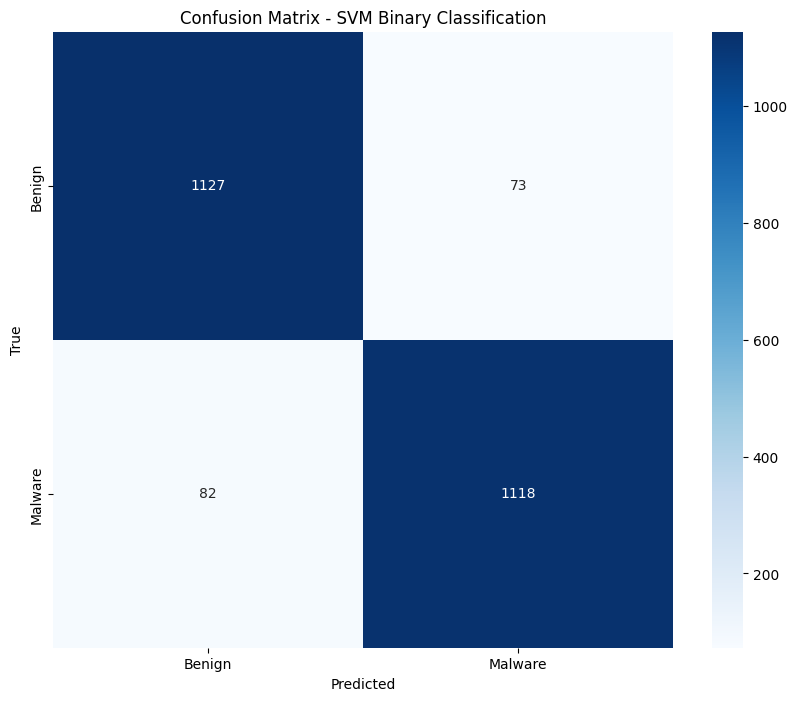

Confusion matrix saved to /content/drive/My Drive/confusion_matrix_svm_binary.png


In [ ]:
# SVM

base_dir = '/content/drive/My Drive/'
csv_path = os.path.join(base_dir, 'combined_static_features_binary_top500.csv')

print(f"Loading dataset from: {csv_path}")
assert os.path.exists(csv_path), f"CSV file not found at {csv_path}"

df = pd.read_csv(csv_path)
print(f"Dataset loaded with shape: {df.shape}")

print("\nClass distribution:")
print(df['label'].value_counts())
print(df['binary_category'].value_counts())

X = df.drop(['app_id', 'category', 'binary_category', 'label'], axis=1)
y = df['label']
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

# Chia ban đầu: train 80% / test 20%
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tách từ train ra thêm validation: validation 20% của train_val (~16% của toàn bộ)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)
# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train mô hình với tập huấn luyện
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Đánh giá trên tập validation
y_val_pred = svm_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_pred = svm_model.predict(X_test_scaled)
y_pred_prob = svm_model.predict_proba(X_test_scaled)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware'], digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware'],
            yticklabels=['Benign', 'Malware'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM Binary Classification')
confusion_matrix_path = os.path.join(base_dir, "confusion_matrix_svm_binary.png")
plt.savefig(confusion_matrix_path)
plt.show()
print(f"Confusion matrix saved to {confusion_matrix_path}")

Loading dataset from: /content/drive/My Drive/combined_static_features_binary_top500.csv
Dataset loaded with shape: (12000, 2031)
Label distribution: label
1    6000
0    6000
Name: count, dtype: int64
Train shape: (7680, 2027), (7680,)
Test shape: (2400, 2027), (2400,)

---- Training Random Forest Model ------
Validation Accuracy: 0.9042
Accuracy: 0.8988

Classification Report:
              precision    recall  f1-score   support

      Benign     0.8795    0.9242    0.9013      1200
     Malware     0.9201    0.8733    0.8961      1200

    accuracy                         0.8988      2400
   macro avg     0.8998    0.8987    0.8987      2400
weighted avg     0.8998    0.8988    0.8987      2400



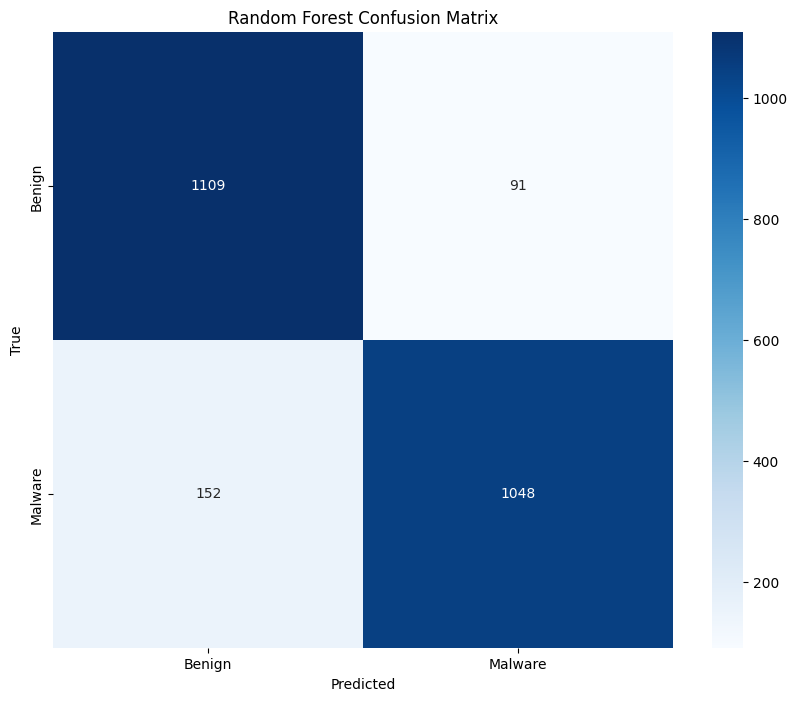

Confusion matrix saved to /content/drive/My Drive/confusion_matrix_rf_binary_top500.png


In [ ]:
# Random Forest

base_dir = '/content/drive/My Drive/'
csv_path = os.path.join(base_dir, 'combined_static_features_binary_top500.csv')
print(f"Loading dataset from: {csv_path}")

df = pd.read_csv(csv_path)
print(f"Dataset loaded with shape: {df.shape}")

if 'label' not in df or set(df['label'].unique()) == {1}:
    df['label'] = df['category'].apply(lambda x: 0 if x.lower().startswith('benign') or x.lower().startswith('bengin') else 1)

X = df.drop(['app_id', 'category', 'binary_category', 'label'], axis=1)
y = df['label']

print("Label distribution:", y.value_counts())

# Chia ban đầu: train_val 80% / test 20%
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Chia tiếp train và validation: 80% train / 20% val từ tập train_val (~64%/16%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

X_train_scaled = X_train
X_val_scaled = X_val
X_test_scaled = X_test

# Train Random Forest
print("\n---- Training Random Forest Model ------")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
# Huấn luyện
rf_model.fit(X_train_scaled, y_train)

# Đánh giá trên validation
y_val_pred = rf_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Đánh giá trên tập test
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware'], digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware'],
            yticklabels=['Benign', 'Malware'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')

# Save the figure
confusion_matrix_path = os.path.join(base_dir, "confusion_matrix_rf_binary_top500.png")
plt.savefig(confusion_matrix_path)
plt.show()
print(f"Confusion matrix saved to {confusion_matrix_path}")

Loading dataset from: /content/drive/My Drive/combined_static_features_binary_top500.csv
Dataset loaded with shape: (12000, 2031)
Feature matrix shape: (12000, 2027)
Label vector shape: (12000,)
Train: (7680, 2027), Val: (1920, 2027), Test: (2400, 2027)

----- Training MLP model -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
240/240 - 6s - 24ms/step - accuracy: 0.8413 - loss: 0.3610 - val_accuracy: 0.9203 - val_loss: 0.1988
Epoch 2/45
240/240 - 1s - 3ms/step - accuracy: 0.9187 - loss: 0.2071 - val_accuracy: 0.9323 - val_loss: 0.1695
Epoch 3/45
240/240 - 1s - 3ms/step - accuracy: 0.9342 - loss: 0.1697 - val_accuracy: 0.9344 - val_loss: 0.1635
Epoch 4/45
240/240 - 1s - 3ms/step - accuracy: 0.9417 - loss: 0.1521 - val_accuracy: 0.9323 - val_loss: 0.1617
Epoch 5/45
240/240 - 1s - 3ms/step - accuracy: 0.9461 - loss: 0.1455 - val_accuracy: 0.9370 - val_loss: 0.1650
Epoch 6/45
240/240 - 1s - 3ms/step - accuracy: 0.9508 - loss: 0.1303 - val_accuracy: 0.9297 - val_loss: 0.1881
Epoch 7/45
240/240 - 1s - 3ms/step - accuracy: 0.9508 - loss: 0.1238 - val_accuracy: 0.9339 - val_loss: 0.1728
Epoch 8/45
240/240 - 1s - 3ms/step - accuracy: 0.9540 - loss: 0.1193 - val_accuracy: 0.9359 - val_loss: 0.1716
Epoch 9/45
240/240 - 1s - 3ms/step - accuracy: 0.9543 - loss: 0.1188 - val_accuracy: 0.9406 - val_loss: 0.1732


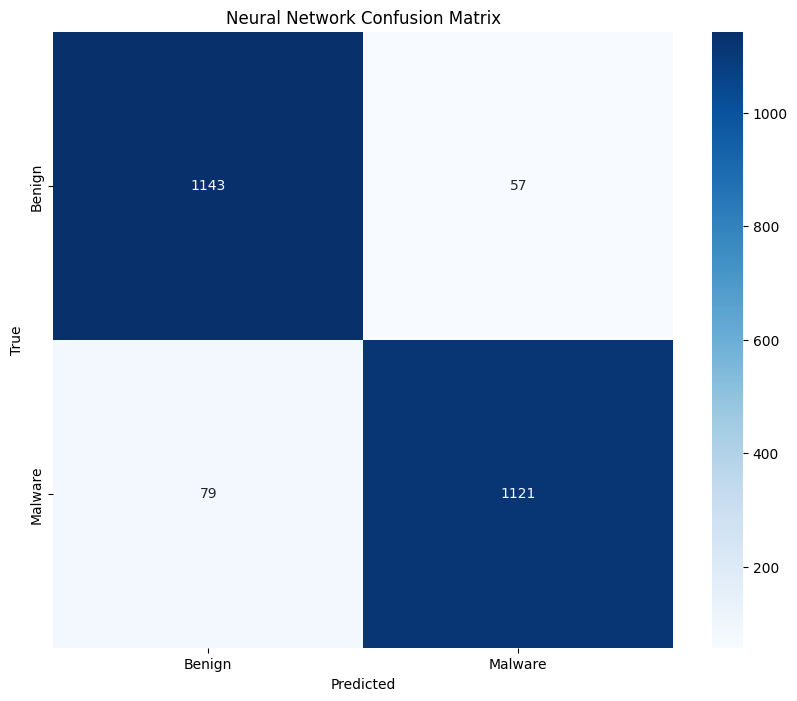

Confusion matrix saved to /content/drive/My Drive/confusion_matrix_MLP_binary_top500.png


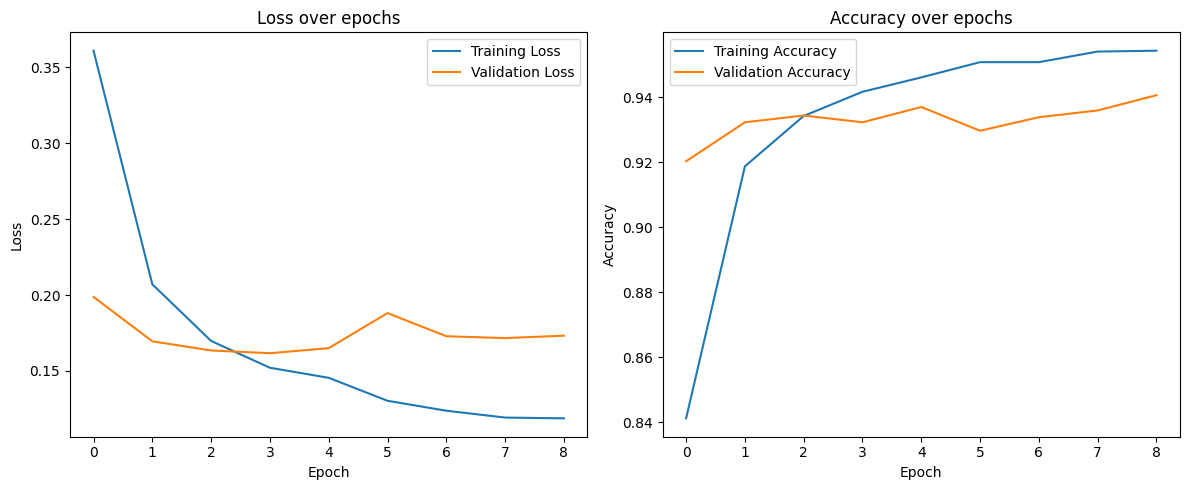

Training history plot saved to /content/drive/My Drive/MLP_binary_training_history_top500.png


In [ ]:
# MLP

base_dir = '/content/drive/My Drive/'
csv_path = os.path.join(base_dir, 'combined_static_features_binary_top500.csv')
print(f"Loading dataset from: {csv_path}")

df = pd.read_csv(csv_path)
print(f"Dataset loaded with shape: {df.shape}")

X = df.drop(['app_id', 'category', 'binary_category', 'label'], axis=1)
y = df['label']
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

# Chia dữ liệu: 80% train_val / 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Chia tiếp: 80% train / 20% validation từ train_val (~64/16)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Training MLP
def train_neural_network():
    print("\n----- Training MLP model -----")

    # Clear any previous TensorFlow session
    tf.keras.backend.clear_session()

    # Define model architecture
    input_dim = X_train.shape[1]

    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_dim=input_dim),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=45,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=2
    )

    # Evaluate on test data
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Get predictions for metrics
    y_pred_prob = model.predict(X_test_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware'], digits=4))

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malware'],
                yticklabels=['Benign', 'Malware'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Neural Network Confusion Matrix')

    # Save the figure
    confusion_matrix_path = os.path.join(base_dir, "confusion_matrix_MLP_binary_top500.png")
    plt.savefig(confusion_matrix_path)
    plt.show()
    print(f"Confusion matrix saved to {confusion_matrix_path}")

    return model, accuracy, history

# Train the model
nn_model, nn_accuracy, nn_history = train_neural_network()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(nn_history.history['loss'], label='Training Loss')
plt.plot(nn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_history.history['accuracy'], label='Training Accuracy')
plt.plot(nn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
history_plot_path = os.path.join(base_dir, "MLP_binary_training_history_top500.png")
plt.savefig(history_plot_path)
plt.show()
print(f"Training history plot saved to {history_plot_path}")

Loading dataset from: /content/drive/My Drive/combined_static_features_binary_top500.csv
Dataset shape: (12000, 2031)
Feature count: 2027
Label distribution:
label
1    6000
0    6000
Name: count, dtype: int64
Training samples: 9600, Test samples: 2400
CNN input shape: (7680, 2027, 1)

===== Starting Genetic Algorithm for CNN Binary Classification =====
Starting Genetic Algorithm optimization for CNN binary classification...

Generation 1/15
Evaluating chromosome 1/15...
Chromosome: {'conv_layers': 2, 'filters': [32, 32, 32], 'kernel_sizes': [3, 9, 5], 'pool_sizes': [4, 3, 4], 'fc_layers': 1, 'fc_neurons': [128, 32], 'dropout_rates': [0.24374137491279022, 0.20567505788522752, 0.3469738469123971, 0.3188100566852474, 0.39571833082894936], 'learning_rate': 0.005, 'batch_size': 32}
Fitness (val accuracy): 0.9255
Evaluating chromosome 2/15...
Chromosome: {'conv_layers': 2, 'filters': [32, 64, 16], 'kernel_sizes': [5, 5, 9], 'pool_sizes': [2, 3, 4], 'fc_layers': 2, 'fc_neurons': [128, 256], 

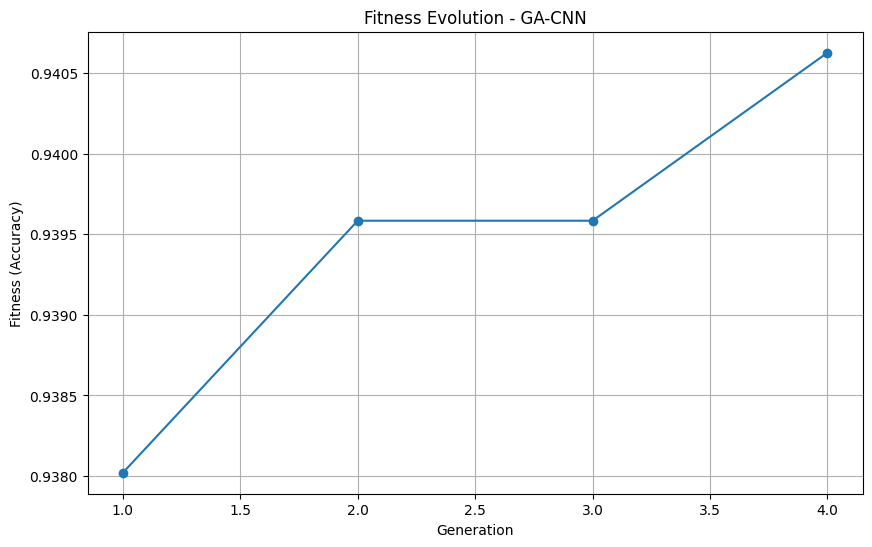

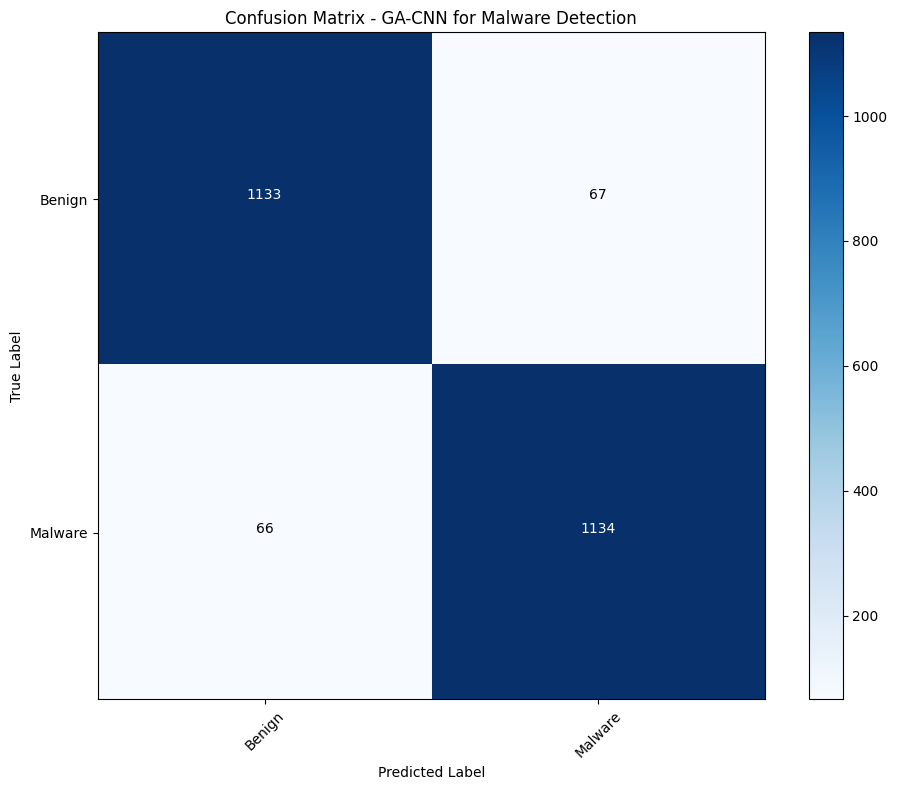

In [ ]:
#GA-CNN

from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import BatchNormalization, Dropout
import zipfile
from google.colab import drive
import glob
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import json
import time

# Load the CSV file
base_dir = '/content/drive/My Drive/'
csv_path = os.path.join(base_dir, 'combined_static_features_binary_top500.csv')
df = pd.read_csv(csv_path)

print(f"Loading dataset from: {csv_path}")
print(f"Dataset shape: {df.shape}")

# Separate features and labels
X = df.drop(['app_id', 'category', 'binary_category', 'label'], axis=1)
y = df['label']

print(f"Feature count: {X.shape[1]}")
print("Label distribution:")
print(y.value_counts())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Initialize scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tiếp tục tách từ tập huấn luyện ra tập validation (20% của train)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Reshape data for Conv1D (thêm chiều kênh)
X_train_cnn = X_train_final.reshape(X_train_final.shape[0], X_train_final.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"CNN input shape: {X_train_cnn.shape}")

class GeneticAlgorithmCNN:
    def __init__(self, population_size=20, generations=15, mutation_rate=0.3, elite_size=3, max_stagnation=5):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.max_stagnation = max_stagnation
        self.chromosome_history = []
        self.fitness_history = []
        self.best_fitness = 0
        self.best_chromosome = None
        self.best_model = None
        self.best_history = None

    def create_initial_population(self):
        population = []
        for _ in range(self.population_size):
            chromosome = {
                'conv_layers': random.randint(1, 3),  # Số lượng lớp tích chập
                'filters': [random.choice([16, 32, 64, 128]) for _ in range(3)],  # Số lượng bộ lọc
                'kernel_sizes': [random.choice([3, 5, 7, 9]) for _ in range(3)],  # Kích thước kernel
                'pool_sizes': [random.choice([2, 3, 4]) for _ in range(3)],  # Kích thước pooling
                'fc_layers': random.randint(1, 2),  # Số lớp fully connected
                'fc_neurons': [random.choice([32, 64, 128, 256]) for _ in range(2)],  # Neuron trong lớp FC
                'dropout_rates': [random.uniform(0.2, 0.5) for _ in range(5)],  # Dropout cho tất cả các lớp
                'learning_rate': random.choice([0.0001, 0.0005, 0.001, 0.005]),
                'batch_size': random.choice([32, 64, 128])
            }
            population.append(chromosome)
        return population

    def calculate_fitness(self, chromosome, verbose=0):
        keras.backend.clear_session()

        # Extract parameters from chromosome
        conv_layers = chromosome['conv_layers']
        filters = chromosome['filters']
        kernel_sizes = chromosome['kernel_sizes']
        pool_sizes = chromosome['pool_sizes']
        fc_layers = chromosome['fc_layers']
        fc_neurons = chromosome['fc_neurons']
        dropout_rates = chromosome['dropout_rates']
        learning_rate = chromosome['learning_rate']
        batch_size = chromosome['batch_size']

        # Build CNN model
        model = keras.Sequential()

        # Input layer + first conv layer
        model.add(Conv1D(filters=filters[0],
                          kernel_size=kernel_sizes[0],
                          activation='relu',
                          input_shape=(X_train_cnn.shape[1], 1),
                          padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_sizes[0]))
        model.add(Dropout(dropout_rates[0]))

        # Additional conv layers
        for i in range(1, conv_layers):
            model.add(Conv1D(filters=filters[i],
                              kernel_size=kernel_sizes[i],
                              activation='relu',
                              padding='same'))
            model.add(BatchNormalization())
            model.add(MaxPooling1D(pool_size=pool_sizes[i]))
            model.add(Dropout(dropout_rates[i]))

        # Flatten before fully connected layers
        model.add(Flatten())

        # Fully connected layers
        for i in range(fc_layers):
            model.add(Dense(fc_neurons[i], activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rates[conv_layers + i]))

        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Early stopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )

        # Train model
        history = model.fit(
            X_train_cnn, y_train_final,
            validation_data=(X_val_cnn, y_val),
            epochs=10,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=verbose
        )

        # Evaluate on validation set
        _, val_accuracy = model.evaluate(X_val_cnn, y_val, verbose=0)
        return val_accuracy, model, history

    def select_parents(self, population, fitnesses):
        selected_parents = []
        elite_indices = np.argsort(fitnesses)[-self.elite_size:]
        for idx in elite_indices:
            selected_parents.append(population[idx])

        while len(selected_parents) < self.population_size:
            tournament_size = 3
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
            winner_idx = tournament_indices[np.argmax(tournament_fitnesses)]
            selected_parents.append(population[winner_idx])
        return selected_parents

    def crossover(self, parents):
        offspring = []
        offspring.extend(parents[:self.elite_size])

        while len(offspring) < self.population_size:
            parent1, parent2 = random.sample(parents, 2)
            child = {}

            # Crossover for scalar values
            for param in ['conv_layers', 'fc_layers', 'learning_rate', 'batch_size']:
                child[param] = parent1[param] if random.random() < 0.5 else parent2[param]

            # Crossover for list values
            for param in ['filters', 'kernel_sizes', 'pool_sizes', 'fc_neurons', 'dropout_rates']:
                child[param] = []
                for i in range(len(parent1[param])):
                    child[param].append(parent1[param][i] if random.random() < 0.5 else parent2[param][i])

            offspring.append(child)
        return offspring

    def mutate(self, offspring):
        for i in range(self.elite_size, len(offspring)):
            if random.random() < self.mutation_rate:
                param = random.choice(['conv_layers', 'filters', 'kernel_sizes', 'pool_sizes', 'fc_layers',
                                       'fc_neurons', 'dropout_rates', 'learning_rate', 'batch_size'])

                if param == 'conv_layers':
                    offspring[i]['conv_layers'] = random.randint(1, 3)
                elif param == 'filters':
                    idx = random.randint(0, len(offspring[i]['filters'])-1)
                    offspring[i]['filters'][idx] = random.choice([16, 32, 64, 128])
                elif param == 'kernel_sizes':
                    idx = random.randint(0, len(offspring[i]['kernel_sizes'])-1)
                    offspring[i]['kernel_sizes'][idx] = random.choice([3, 5, 7, 9])
                elif param == 'pool_sizes':
                    idx = random.randint(0, len(offspring[i]['pool_sizes'])-1)
                    offspring[i]['pool_sizes'][idx] = random.choice([2, 3, 4])
                elif param == 'fc_layers':
                    offspring[i]['fc_layers'] = random.randint(1, 2)
                elif param == 'fc_neurons':
                    idx = random.randint(0, len(offspring[i]['fc_neurons'])-1)
                    offspring[i]['fc_neurons'][idx] = random.choice([32, 64, 128, 256])
                elif param == 'dropout_rates':
                    idx = random.randint(0, len(offspring[i]['dropout_rates'])-1)
                    offspring[i]['dropout_rates'][idx] = random.uniform(0.2, 0.5)
                elif param == 'learning_rate':
                    offspring[i]['learning_rate'] = random.choice([0.0001, 0.0005, 0.001, 0.005])
                elif param == 'batch_size':
                    offspring[i]['batch_size'] = random.choice([32, 64, 128])

        return offspring

    def run(self):
        print("Starting Genetic Algorithm optimization for CNN binary classification...")
        start_time = time.time()
        population = self.create_initial_population()
        generations_without_improvement = 0

        for generation in range(self.generations):
            print(f"\nGeneration {generation+1}/{self.generations}")
            fitnesses = []
            models = []
            histories = []

            for i, chromosome in enumerate(population):
                print(f"Evaluating chromosome {i+1}/{len(population)}...")
                fitness, model, history = self.calculate_fitness(chromosome)
                fitnesses.append(fitness)
                models.append(model)
                histories.append(history)
                print(f"Chromosome: {chromosome}\nFitness (val accuracy): {fitness:.4f}")

            best_idx = np.argmax(fitnesses)
            current_best_fitness = fitnesses[best_idx]
            current_best_chromosome = population[best_idx]

            if current_best_fitness > self.best_fitness:
                self.best_fitness = current_best_fitness
                self.best_chromosome = current_best_chromosome
                self.best_model = models[best_idx]
                self.best_history = histories[best_idx]
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1

            self.chromosome_history.append(self.best_chromosome)
            self.fitness_history.append(self.best_fitness)

            print(f"Generation {generation+1} best fitness: {current_best_fitness:.4f}")
            print(f"Overall best fitness: {self.best_fitness:.4f}")

            # Early stopping check
            if generations_without_improvement >= self.max_stagnation:
                print(f"Early stopping: No improvement in {self.max_stagnation} generations")
                break

            # Check if already reached excellent performance
            if self.best_fitness >= 0.995:
                print("Reached near-perfect accuracy, stopping early")
                break

            # Check time limit (optional - 1 hour)
            if time.time() - start_time > 3600:
                print("Time limit reached (1 hour)")
                break

            parents = self.select_parents(population, fitnesses)
            offspring = self.crossover(parents)
            population = self.mutate(offspring)

        print("\nGenetic Algorithm completed!")
        print(f"Best chromosome: {self.best_chromosome}")
        print(f"Best fitness (val accuracy): {self.best_fitness:.4f}")
        print(f"Total running time: {(time.time() - start_time) / 60:.2f} minutes")

        return self.best_chromosome, self.best_fitness, self.best_model

    def plot_fitness_evolution(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.fitness_history) + 1), self.fitness_history, marker='o')
        plt.title('Fitness Evolution - GA-CNN')
        plt.xlabel('Generation')
        plt.ylabel('Fitness (Accuracy)')
        plt.grid(True)
        evolution_path = os.path.join(base_dir, "ga_cnn_fitness_evolution_binary_t500.png")
        plt.savefig(evolution_path)
        print(f"Fitness evolution plot saved to {evolution_path}")

print("\n===== Starting Genetic Algorithm for CNN Binary Classification =====")
ga = GeneticAlgorithmCNN(population_size=15, generations=15, mutation_rate=0.3, elite_size=3, max_stagnation=5)
best_chromosome, best_fitness, best_model_ga = ga.run()
ga.plot_fitness_evolution()

# Evaluate and save the best model
loss, accuracy = best_model_ga.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Get predictions
y_pred_prob = best_model_ga.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report with 4 decimal places
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware'], digits=4))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot and save confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - GA-CNN for Malware Detection')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malware'], rotation=45)
plt.yticks(tick_marks, ['Benign', 'Malware'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations to confusion matrix cells
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
cm_path = os.path.join(base_dir, "confusion_matrix_ga_cnn_binary_t500.png")
plt.savefig(cm_path)
print(f"Confusion matrix saved to {cm_path}")

# Save best configuration
best_config = {
    'best_chromosome': best_chromosome,
    'best_fitness': best_fitness,
    'test_accuracy': float(accuracy)
}
with open(os.path.join(base_dir, "ga_cnn_best_configuration_binary_t500.json"), 'w') as f:
    json.dump(best_config, f, indent=4)

print("\n===== Genetic Algorithm CNN Binary Training Complete =====")